# Imports and Deterministic Behaviour

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import re
import numpy as np
import matplotlib.pyplot as plt

import data_operations as data_ops

import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D,  MaxPooling1D, BatchNormalization, GlobalMaxPooling1D

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
DATA_DIR = "./data/SAVEE"

TRAIN_SIZE, VAL_SIZE, TEST_SIZE = (300, 100, 80)

SAMPLE_RATE_HZ = 44100

# Load audio and Get Label functions

In [3]:
def get_label(file_path):
  parts = re.sub('.+\_|[0-9]+.wav', '', file_path)
  return parts

In [4]:
filenames = [f'{DATA_DIR}/{p}' for p in os.listdir(DATA_DIR)]
np.random.shuffle(filenames)
labels = list(map(get_label, filenames))

In [5]:
train_files, train_labels = (filenames[:TRAIN_SIZE], labels[:TRAIN_SIZE])
val_files, val_labels = (filenames[TRAIN_SIZE: TRAIN_SIZE + VAL_SIZE], labels[TRAIN_SIZE: TRAIN_SIZE + VAL_SIZE])
test_files, test_labels = (filenames[-TEST_SIZE:], labels[-TEST_SIZE:])

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))
(train_files[0], train_labels[0])

Training set size 300
Validation set size 100
Test set size 80


('./data/SAVEE/JE_n02.wav', 'n')

In [6]:
operations = [
    data_ops.ReadFile(),
    data_ops.DecodeWav(),
    data_ops.Squeeze(),
    data_ops.Crop(SAMPLE_RATE_HZ * 8),
    data_ops.ZeroPad(SAMPLE_RATE_HZ * 8),
    data_ops.CastToFloat(),
    data_ops.Reshape(SAMPLE_RATE_HZ * 8)
]

train_ds = tfio.audio.AudioIODataset.from_tensor_slices((train_files, train_labels))
# train_ds = tfio.audio.AudioIODataset.from_tensor_slices(train_files)
for o in operations:
    train_ds = train_ds.map(o, num_parallel_calls=tf.data.AUTOTUNE)

val_ds = tfio.audio.AudioIODataset.from_tensor_slices((val_files, val_labels))
# val_ds = tfio.audio.AudioIODataset.from_tensor_slices(val_files)
for o in operations:
    val_ds = val_ds.map(o, num_parallel_calls=tf.data.AUTOTUNE)

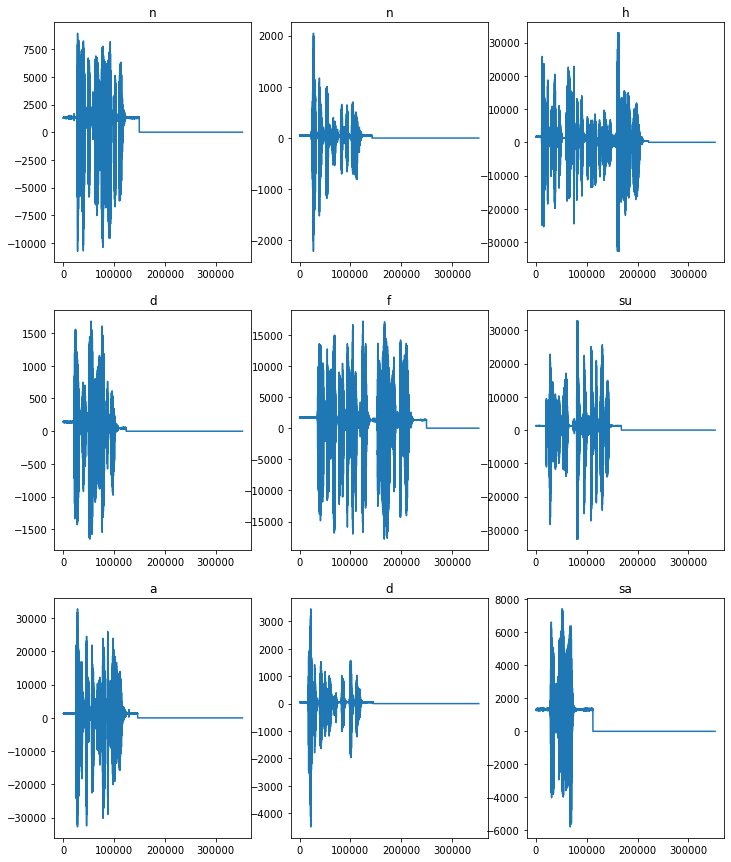

In [7]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(12, 15))

for i, (audio, label) in enumerate(train_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

## CNN Architecture
 * 6x 1D + Batch norm + max pooling
 * 1x 1D + Batch norm + global max pooling
 * 2x dense layer

In [8]:
first_filter_size =  (32, 21)
filters = [64, 128, 256, 512, 1024]
sizes = [19, 17, 15, 13, 11]
middle_filters_size = list(zip(filters, sizes))

activation= 'relu'
pool_size = 2

last_filter_size =  (1024, 9)

In [9]:
model = Sequential()

# first layer
# input shape (None, n) = variable-length sequences of n-dimensional vectors
model.add(Conv1D(first_filter_size[0], first_filter_size[1], activation = activation, input_shape=(8 * SAMPLE_RATE_HZ, 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size = pool_size))

# # middle layers
for (filter_size, kernel_size) in middle_filters_size:
    model.add(Conv1D(filter_size, kernel_size, activation = activation))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size = pool_size))

# # last layer
model.add(Conv1D(last_filter_size[0], last_filter_size[1], activation = activation))
model.add(BatchNormalization())
model.add(GlobalMaxPooling1D())

# model.add(Flatten())
model.add(Dense(128, activation=activation))
model.add(Dense(7, activation='softmax'))

model.summary()

opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 352780, 32)        704       
                                                                 
 batch_normalization (BatchN  (None, 352780, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 176390, 32)       0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 176372, 64)        38976     
                                                                 
 batch_normalization_1 (Batc  (None, 176372, 64)       256       
 hNormalization)                                                 
                                                        

In [10]:
# model.fit(train_files['padded'].map(lambda x : tf.convert_to_tensor(x.numpy())), train_files['label'], epochs=10, validation_data=(val_files['padded'].map(lambda x : tf.convert_to_tensor(x.numpy())), val_files['label']))
model.fit(train_ds.map(lambda x, l: (tf.reshape(x, [352800, 1]), l)), batch_size=100, epochs=10, validation_data=val_ds)

Epoch 1/10


ValueError: in user code:

    File "/home/jack/.conda/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/home/jack/.conda/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jack/.conda/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/home/jack/.conda/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 889, in train_step
        y_pred = self(x, training=True)
    File "/home/jack/.conda/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer "conv1d" (type Conv1D).
    
    Negative dimension size caused by subtracting 21 from 1 for '{{node sequential/conv1d/Conv1D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](sequential/conv1d/Conv1D/ExpandDims, sequential/conv1d/Conv1D/ExpandDims_1)' with input shapes: [352800,1,1,1], [1,21,1,32].
    
    Call arguments received by layer "conv1d" (type Conv1D):
      • inputs=tf.Tensor(shape=(352800, 1, 1), dtype=float32)
